# Analyze Cloudiness across diurnal cycle  

Requirements: 

- A GOOGLE cloud project linked to your GOOGLE account


### My project 

Google account: gelieza.gk@gmail.com


cloud project ID: sample-project-452812 


cloud project name: Sample Project


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ee
import geemap
import math
import datetime
import calendar
import pytz
import pvlib

In [2]:
# Authorization and initialization of the GEE
# OBS: You must create our own project on Google
# Authenticate Earth Engine
ee.Authenticate()
#
# Initialize Earth Engine
my_project_name = 'sample-project-452812' # use here the name of your own project on Google
ee.Initialize(project=my_project_name)

In [35]:
# Convert degree to radian
def deg2rad(deg):
    return deg * math.pi / 180

# Define the center of the bounding box (Bergen, Norway)
CENTER_LAT = 60.39
CENTER_LON = 5.33

# Approximate degree adjustments for 100km x 100km box
DEG_LAT_TO_KM = 111.412  # 1 degree latitude at 60° converted to km (https://en.wikipedia.org/wiki/Latitude)
DEG_LON_TO_KM = 111.317 * math.cos(deg2rad(CENTER_LAT))  # 1 degree longitude converted to km
LAT_OFFSET = 250 / DEG_LAT_TO_KM  # ~100km north/south
LON_OFFSET = 250 / DEG_LON_TO_KM  # ~100km east/west (varies with latitude, approximation)

# Define the bounding box
BBOX = {
    "north": CENTER_LAT + LAT_OFFSET,
    "south": CENTER_LAT - LAT_OFFSET,
    "west": CENTER_LON - LON_OFFSET,
    "east": CENTER_LON + LON_OFFSET
}

print(BBOX)

# Geometry Rectangle of Form minLng, minLat, maxLng, maxLat
bergen_roi = ee.Geometry.Rectangle([BBOX["west"], BBOX["south"], BBOX["east"], BBOX["north"]])

Map = geemap.Map(center=[CENTER_LAT, CENTER_LON], zoom=6, width=800, height=400)

# Add the geometry to the map
Map.addLayer(bergen_roi, {"color": "red"}, "Bergen ROI")

# Display the weather stations
stations = {
    #"Fana - Stend": (60.261870, 5.302989),
    "Flesland Bergen": (60.292792, 5.222689),
    "Florida": (60.3833, 5.3333)
}

for name, (lat, lon) in stations.items():
    point = ee.Geometry.Point([lon, lat])
    Map.addLayer(point, {"color": "blue"}, name)
    
# Add cloudiness map 
tcdc = ee.ImageCollection("NOAA/NCEP_DOE_RE2/total_cloud_coverage").filterBounds(bergen_roi).filterDate("2024-01-01", "2025-12-31").select("tcdc")
sample_image = tcdc.first().clip(bergen_roi)

cloudiness_vis_params = {'min': 0, 'max': 100, 'palette': ['white', 'black']}

Map.addLayer(sample_image, cloudiness_vis_params, "Cloudiness (TCDC)")

# Display the map
Map

{'north': 62.633923455283096, 'south': 58.146076544716905, 'west': 0.7846296588767894, 'east': 9.875370341123212}


Map(center=[60.39, 5.33], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

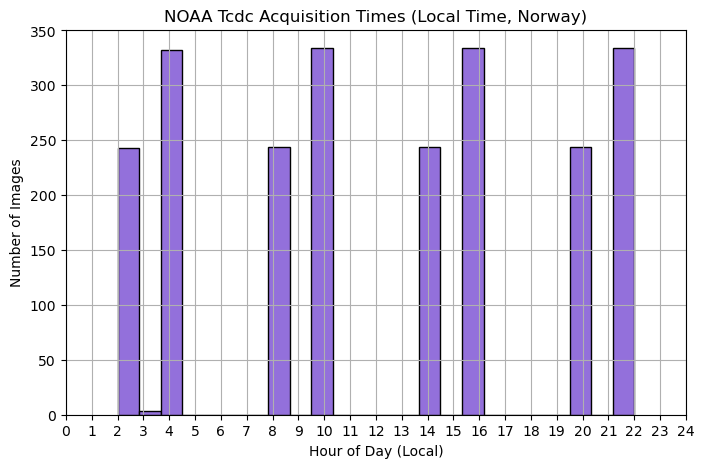

In [36]:
# Plot timestamps
# Extract all timestamps
timestamps = tcdc.aggregate_array('system:time_start').getInfo()

# Convert to hour-of-day in LOCAL time (Norway, accounts for DST)
norway = pytz.timezone('Europe/Oslo')
hours_local = [norway.fromutc(datetime.datetime.fromtimestamp(ts / 1000)).hour +
                norway.fromutc(datetime.datetime.fromtimestamp(ts / 1000)).minute / 60.0
                for ts in timestamps]

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(hours_local, bins=24, color='mediumpurple', edgecolor='black')
plt.title('NOAA Tcdc Acquisition Times (Local Time, Norway)')
plt.xlabel('Hour of Day (Local)')
plt.ylabel('Number of Images')
plt.grid(True)
plt.xticks(range(0, 25))
plt.show()

   hour  month  pixel       tcdc
0     0      1      0  51.700001
1     0      1      1  33.700001
2     0      1      2  39.700001
3     0      1      3  75.000000
4     0      1      4  55.900002


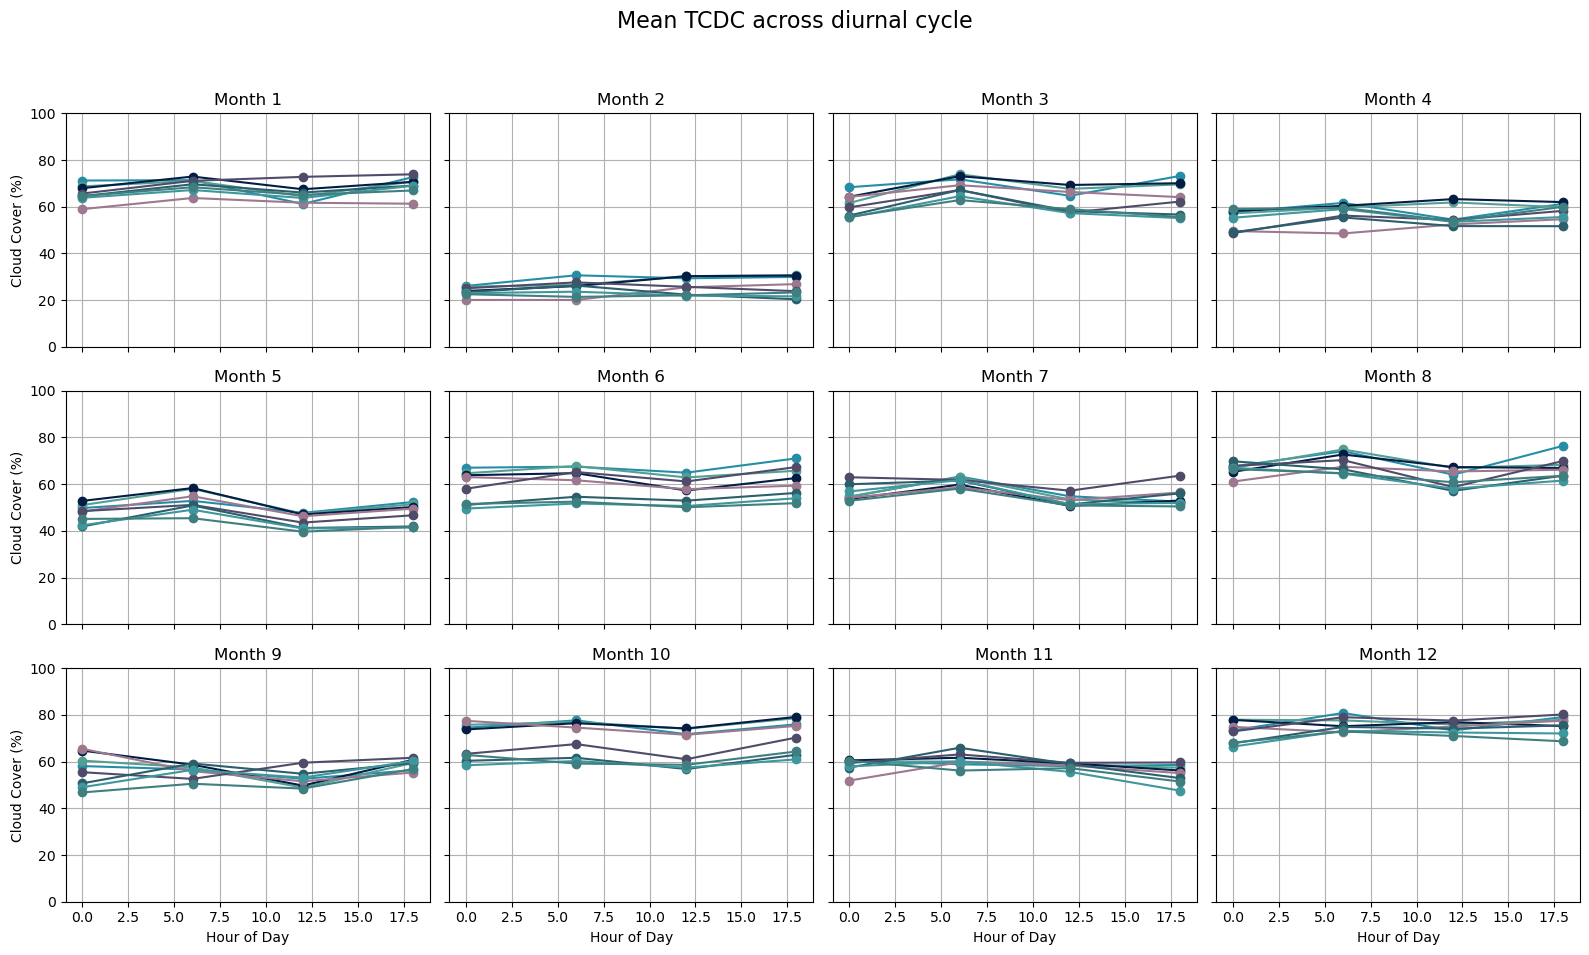

In [ ]:
#TODO: define "land" region and "ocean" region, get average pixel from this and calculate the mean cloudiness values across diurnal cycle
# Function to extract time and mean per pixel
def extract_hour_month(image):
    time = ee.Date(image.get('system:time_start'))
    hour = time.get('hour')
    month = time.get('month')
    reducer = image.reduceRegion(
        reducer=ee.Reducer.toList().unweighted(),
        geometry=bergen_roi,
        maxPixels=1e4
    )
    values = ee.List(reducer.get('tcdc')).map(lambda v: ee.Number(v).toFloat())
    return ee.Feature(None, {
        'hour': hour,
        'month': month,
        'values': values
    })

# Apply function to all images
features = tcdc.map(extract_hour_month)

# Download and process to Pandas
fc = ee.FeatureCollection(features).getInfo()

# Flatten the list into rows per pixel
records = []
for f in fc['features']:
    hour = f['properties']['hour']
    month = f['properties']['month']
    values = f['properties']['values']
    for i, val in enumerate(values):
        records.append({'hour': hour, 'month': month, 'pixel': i, 'tcdc': val})

df = pd.DataFrame(records)
print(df.head())

# Plot one figure per pixel
fig, axs = plt.subplots(3, 4, figsize=(16, 10), sharex=True, sharey=True)
fig.suptitle(f'Mean TCDC across diurnal cycle', fontsize=16)
pixel_colors = ['#258EA6', '#549F93', '#031D44', '#9E788F', '#514B6A', '#2C5E6C', '#3D979D', '#407F80']

for month in range(1, 13):
    ax = axs[(month - 1) // 4][(month - 1) % 4]
    for pixel_id in df['pixel'].unique():
        sub = df[(df['pixel'] == pixel_id) & (df['month'] == month)]
        grouped = sub.groupby('hour')['tcdc'].mean()
        grouped.plot(kind='line', ax=ax, marker='o', color=pixel_colors[pixel_id])
    ax.set_title(f'Month {month}')
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Cloud Cover (%)')
    ax.set_ylim(0, 100)
    ax.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()